In [1]:
from discretize import TensorMesh
from SimPEG import maps
from simpegEM1D.simulation import EM1DFMSimulation
from simpegEM1D.survey import EM1DSurveyFD
from simpegEM1D.sources import *
from simpegEM1D.receivers import *
from simpegEM1D import analytics
import numpy as np
import matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Set up for EM1D program

## Step1: Generate mesh

In [2]:
nearthick = np.logspace(-1, 1, 5)
deepthick = np.logspace(1, 2, 10)
hx = np.r_[nearthick, deepthick]
mesh1D = TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 0.]
print(depth)
print(-np.diff(depth))
print(-mesh1D.gridN[0:-1])

[-0.00000000e+00 -1.00000000e-01 -4.16227766e-01 -1.41622777e+00
 -4.57850543e+00 -1.45785054e+01 -2.45785054e+01 -3.74940021e+01
 -5.41750074e+01 -7.57193543e+01 -1.03544948e+02 -1.39483085e+02
 -1.85898973e+02 -2.45847398e+02 -3.23273767e+02]
[ 0.1         0.31622777  1.          3.16227766 10.         10.
 12.91549665 16.68100537 21.5443469  27.82559402 35.93813664 46.41588834
 59.94842503 77.42636827]
[-0.00000000e+00 -1.00000000e-01 -4.16227766e-01 -1.41622777e+00
 -4.57850543e+00 -1.45785054e+01 -2.45785054e+01 -3.74940021e+01
 -5.41750074e+01 -7.57193543e+01 -1.03544948e+02 -1.39483085e+02
 -1.85898973e+02 -2.45847398e+02 -3.23273767e+02]


## Step2: Set survey parameters

In [3]:
rx_location = np.array([8., 0., 0.])
src_location = np.array([0., 0., 0.])
frequencies = np.logspace(-2, 8, 61)
I = 1.
a = 1.
field_type = "secondary" # "total", "ppm"

# Receiver list
receiver_list = []
receiver_list.append(
    HarmonicPointReceiver(
        rx_location, frequencies, orientation="z",
        field_type="secondary", component="real"
    )
)
receiver_list.append(
    HarmonicPointReceiver(
        rx_location, frequencies, orientation="z",
        field_type="secondary", component="imag"
    )
)

# Sources
source_list = [
    HarmonicMagneticDipoleSource(
        receiver_list=receiver_list, location=src_location, orientation="z", I=I
    )
]

# source_list = [
#     HarmonicHorizontalLoopSource(
#         receiver_list=receiver_list, location=src_location, a=a, I=I
#     )
# ]

# Survey
FDsurvey = EM1DSurveyFD(source_list)

Colesurvey = EM1DSurveyFD(source_list)


## Step3: Set mappings (Exponential and Cole-Cole maps)

### Exponential map

### $$ m = log(\sigma) $$

### $$ M_{exp}(m) = e^{m}$$

### Cole-Cole map

$$ m(\sigma_{\infty}, \eta, \tau, c; \omega) = \sigma_{\infty} - \sigma_{\infty}\eta \frac{1}{1+(1-\eta)(\imath\omega\tau)^c}$$

In [4]:
sig_half = 1e-2
chi_half = 0.
Expmap = maps.ExpMap(mesh1D)
tau =  np.ones(nlay, dtype=float)*1e-1
eta = np.ones(nlay, dtype=float)*0.5
c = np.ones(nlay, dtype=float)*0.88

In [5]:
m_1D = np.log(np.ones(nlay)*sig_half)

In [6]:
# Conductivity
simFD = EM1DFMSimulation(
    survey=FDsurvey, depth=depth , sigmaMap=Expmap,
    chi=np.zeros(nlay)
)

# Hz = simFD.dpred(m_1D)
Hz = simFD.fields(m_1D)
print(np.shape(Hz))
print(Hz)

SAD I DIDN'T FIND IT
SAD I DIDN'T FIND IT
(122,)
[-5.46799058e-17 -1.16896402e-16 -2.50681887e-16 -5.38655317e-16
 -1.15903476e-15 -2.49280581e-15 -5.35440132e-15 -1.14648491e-14
 -2.43827071e-14 -5.11171297e-14 -1.04109185e-13 -2.01013662e-13
 -3.58829149e-13 -6.06720506e-13 -1.06394230e-12 -1.88584081e-12
 -3.33558439e-12 -5.90958825e-12 -1.04968251e-11 -1.86339180e-11
 -3.30761887e-11 -5.87189264e-11 -1.04226195e-10 -1.84935729e-10
 -3.27993936e-10 -5.81400117e-10 -1.02990773e-09 -1.82292821e-09
 -3.22336302e-09 -5.69275377e-09 -1.00390953e-08 -1.76720061e-08
 -3.10401974e-08 -5.43749881e-08 -9.49400531e-08 -1.65102293e-07
 -2.85699664e-07 -4.91382245e-07 -8.38792464e-07 -1.41847289e-06
 -2.37086483e-06 -3.90488430e-06 -6.31284960e-06 -9.96569115e-06
 -1.52549352e-05 -2.24233036e-05 -3.12054975e-05 -4.02239115e-05
 -4.62349237e-05 -4.37081555e-05 -2.58109982e-05  1.19223605e-05
  6.56056428e-05  1.19607359e-04  1.54009845e-04  1.62201830e-04
  1.57645995e-04  1.55099666e-04  1.55346

In [7]:
# Frequency-dependent conductivity
simCole = EM1DFMSimulation(
    survey=Colesurvey, depth=depth, sigmaMap=Expmap,
    eta=eta, tau=tau, c=c,
    chi=np.zeros(nlay)
)

# HzCole = simCole.dpred(m_1D)
HzCole = simCole.fields(m_1D)
Hzanal = analytics.Hzanal(sig_half, frequencies, 8., 'secondary')
print(np.shape(HzCole))
print(HzCole)

SAD I DIDN'T FIND IT
SAD I DIDN'T FIND IT
(122,)
[ 5.53757290e-15  1.13879984e-14  2.33869700e-14  4.80265611e-14
  9.85321185e-14  2.01925484e-13  4.13070866e-13  8.42699459e-13
  1.71187054e-12  3.45402835e-12  6.89324945e-12  1.35141956e-11
  2.57469873e-11  4.69381200e-11  8.03625965e-11  1.26323796e-10
  1.80484076e-10  2.34605771e-10  2.81668418e-10  3.17628539e-10
  3.40249353e-10  3.46382970e-10  3.29112985e-10  2.74424515e-10
  1.56052188e-10 -7.34649201e-11 -4.98587742e-10 -1.26861497e-09
 -2.64647850e-09 -5.09387832e-09 -9.41909607e-09 -1.70321780e-08
 -3.03824285e-08 -5.37019594e-08 -9.42554839e-08 -1.64411243e-07
 -2.85008894e-07 -4.90700650e-07 -8.38131544e-07 -1.41784724e-06
 -2.37029252e-06 -3.90438704e-06 -6.31245224e-06 -9.96542029e-06
 -1.52548159e-05 -2.24233543e-05 -3.12057216e-05 -4.02242882e-05
 -4.62353997e-05 -4.37086455e-05 -2.58114013e-05  1.19221248e-05
  6.56055912e-05  1.19607430e-04  1.54009937e-04  1.62201883e-04
  1.57646011e-04  1.55099671e-04  1.55346

In [8]:
matplotlib.rcParams['font.size'] = 16

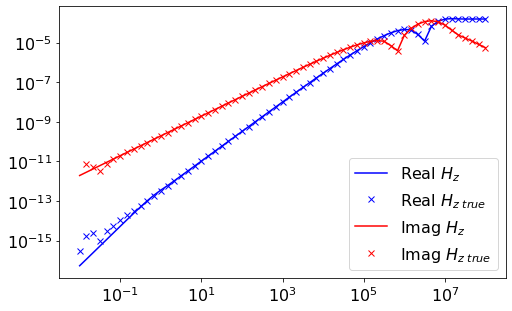

In [9]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
ax.loglog(frequencies, np.abs(Hz[0:len(frequencies)]), 'b-')
ax.loglog(frequencies, np.abs(np.real(Hzanal)), 'bx')
ax.loglog(frequencies, np.abs(Hz[len(frequencies):]), 'r-')
ax.loglog(frequencies, np.abs(np.imag(Hzanal)), 'rx')
legend(('Real $H_{z}$', 'Real $H_{z \ true}$', 'Imag $H_{z}$', 'Imag $H_{z \ true}$'))

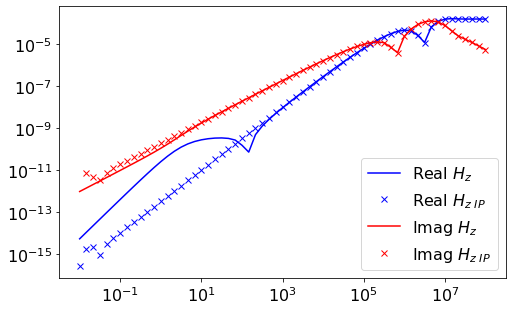

In [10]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
ax.loglog(frequencies, np.abs(HzCole[0:len(frequencies)]), 'b-')
ax.loglog(frequencies, np.abs(np.real(Hzanal)), 'bx')
ax.loglog(frequencies, np.abs(HzCole[len(frequencies):]), 'r-')
ax.loglog(frequencies, np.abs(np.imag(Hzanal)), 'rx')
legend(('Real $H_{z}$', 'Real $H_{z \ IP}$', 'Imag $H_{z}$', 'Imag $H_{z \ IP}$'))